# Traditional NLP model Baseline on Kaggle Amazon review dataset

## Step 1 - Data Loading and Preprocessing(Kaggle)

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
# load the tsv data
df = pd.read_csv('../data/capstone/amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', on_bad_lines="skip")
print(len(df))

6900886


In [3]:
# extract the columns to down scale the dataset
df = df[['star_rating', 'review_headline', 'review_body']]
df = df.head(1000)
print(df.shape)

(1000, 3)


In [4]:
df = df.query('star_rating != 3.0')
df = df.reset_index().rename(columns = {'index': 'Id'})
df.shape

(953, 4)

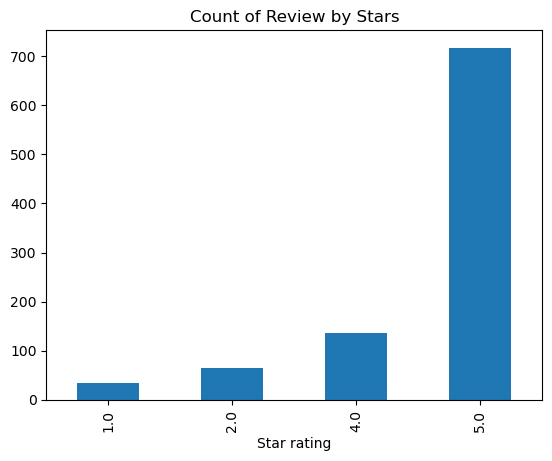

In [5]:
# visualize data distribution
ax = df['star_rating'].value_counts().sort_index().plot(kind='bar', title='Count of Review by Stars')
ax.set_xlabel('Star rating')
plt.show()

## Step 2 - run pipeline

In [60]:
def pipeline_eval(pipe, data, positive_label, negative_label):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
      text = row['review_body']
      result = pipe(text)[0]
      result['Id'] = row['Id']
      res_dict[i] = result
      if row['star_rating'] < 3.0:
        total[0] += 1
        if result['label'] == negative_label:
          correct[0] += 1
      elif row['star_rating'] > 3.0:
        total[1] += 1
        if result['label'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [7]:
from transformers import pipeline

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [8]:
!nvidia-smi

Wed Feb  7 20:19:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   33C    P0              45W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Bert Pipeline

In [9]:
pipe_bert = pipeline("text-classification", model="fabriceyhc/bert-base-uncased-amazon_polarity", device=0)

In [10]:
# output example
example = df['review_body'][0]
pipe_bert(example)

[{'label': 'positive', 'score': 0.9992735981941223}]

In [61]:
# evaluate the dataset with BERT
bert_res, bert_correct, bert_total, bert_runtime = pipeline_eval(pipe_bert, df, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [62]:
# calculate the accuracy
print(f'==> Negative Accuracy: {bert_correct[0]/bert_total[0]}')
print(f'==> Positive Accuracy: {bert_correct[1]/bert_total[1]}')
print(f'==> Total Accuracy: {np.sum(bert_correct) / np.sum(bert_total)}')
print(f'==> Total Runtime: {bert_runtime}')

==> Negative Accuracy: 0.9696969696969697
==> Positive Accuracy: 0.9260143198090692
==> Total Accuracy: 0.9306296691568837
==> Total Runtime: 12.868469476699829


### DistilBert Pipeline

In [63]:
pipe_distilbert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon", device=0)

In [14]:
# output example
example = df['review_body'][787]
print(example)
pipe_distilbert(example)

It is not the most creative work but it is certainly interesting.  I think, the movie, however, was horrible.  How would anybody who didn't read the book be able to understand the movie.  No one in a million years would be able to make the connection that the black slab that appears on Earth 3 million years ago is what gave early man the idea of using bone fragments as a mean for hunting for food.  The book is definitely 10 times better than the movie.    If anybody has a comment or anything to say of interest feel free to email me at vpatel@flinet.com


[{'label': 'positive', 'score': 0.8007069826126099}]

In [64]:
# evaluate the dataset on DistilBert
distilbert_res, distilbert_correct, distilbert_total, distilbert_runtime = pipeline_eval(pipe_distilbert, df, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [65]:
# calculate the accuracy
print(f'==> Negative Accuracy: {distilbert_correct[0]/distilbert_total[0]}')
print(f'==> Positive Accuracy: {distilbert_correct[1]/distilbert_total[1]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct) / np.sum(distilbert_total)}')
print(f'==> Total Runtime: {distilbert_runtime}')

==> Negative Accuracy: 0.9090909090909091
==> Positive Accuracy: 0.9630071599045346
==> Total Accuracy: 0.9573105656350054
==> Total Runtime: 7.414007663726807


### GPT2 Pipeline


In [17]:
pipe_gpt2 = pipeline("text-classification", model="mnoukhov/gpt2-imdb-sentiment-classifier")

In [18]:
# output example
example = df['review_body'][102]
print(example)
pipe_gpt2(example)

Hey, I'm female and I loved this book.  I thought it was very funny and actually quite sweet.  Sure, the guy was kind of a dope, but aren't we all?? (women included!


[{'label': 'LABEL_1', 'score': 0.9998786449432373}]

In [66]:
# evaluate the dataset on GPT2
gpt2_res, gpt2_correct, gpt2_total, gpt2_runtime = pipeline_eval(pipe_gpt2, df, 'LABEL_1', 'LABEL_0')

  0%|          | 0/953 [00:00<?, ?it/s]

76th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>


In [20]:
# calculate the accuracy
print(f'==> Negative Accuracy: {gpt2_correct[0]/gpt2_total[0]}')
print(f'==> Positive Accuracy: {gpt2_correct[1]/gpt2_total[1]}')
print(f'==> Total Accuracy: {np.sum(gpt2_correct) / np.sum(gpt2_total)}')
print(f'==> Total Runtime: {gpt2_runtime}')

==> Negative Accuracy: 0.8888888888888888
==> Positive Accuracy: 0.931924882629108
==> Total Accuracy: 0.9274447949526814
==> Total Runtime: 162.1988480091095


### Roberta Pipeline

In [21]:
pipe_roberta = pipeline("text-classification", model="siebert/sentiment-roberta-large-english", device = 0)

In [22]:
# output example
example = df['review_body'][93]
print(example)
pipe_roberta(example)

I was checking on this book because I just recommended it as an acquisition for the library at the community colllege where I teach.  The book describes the life of a brilliant Nobel Prize-winning physicist, and shows him as a completely accessible human being.  He gives a marvelously entertaining account of some of the experiments he conducted while a college undergraduate - all of them completely understandable to a layperson.  But the book continues through his adult life: his attempts to learn Japanese, his experiences as a patron and legal defender of a local strip club, his encounters with military stuffed shirts during WWII, and dozens of other adventures.  If you want to convince yourself or someone else that it's possible to be a brilliant scientist and a real human being simultaneously, then this is the book.  Both as entertainment and as information, it's a smashing success


[{'label': 'POSITIVE', 'score': 0.9989196062088013}]

In [83]:
# evaluate the dataset on Roberta
roberta_res, roberta_correct, roberta_total, roberta_runtime = pipeline_eval(pipe_roberta, df, 'POSITIVE', 'NEGATIVE')

  0%|          | 0/953 [00:00<?, ?it/s]

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
776th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
785th row broke. The input text is too long.
<class 'IndexError'>
812th row b

In [82]:
# calculate the accuracy
print(f'==> Negative Accuracy: {roberta_correct[0]/roberta_total[0]}')
print(f'==> Positive Accuracy: {roberta_correct[1]/roberta_total[1]}')
print(f'==> Total Accuracy: {np.sum(roberta_correct) / np.sum(roberta_total)}')
print(f'==> Total Runtime: {roberta_runtime}')

==> Negative Accuracy: 0.9591836734693877
==> Positive Accuracy: 0.961768219832736
==> Total Accuracy: 0.9614973262032086
==> Total Runtime: 26.068150281906128


## Step 3 - results evaluation


> experiment results on 1000 rows(ignore star_rating==3) of amazon reviews






|Model|Bert|DistilBert|GPT2|Roberta|
|-|-|-|-|-|
|Accuracy|0.931|0.957|0.927|**0.961**|
|Runtime(GPU)/s|23.34|**14.03**|-|64.72|
|Runtime(CPU)/s|408.1|**168.5**|397.4|1173.81|


> combine the results from 4 NLP models

In [86]:
results_df = df.copy()

# merge bert results
bert_df = pd.DataFrame(bert_res).T
bert_df = bert_df.rename(columns={'label':'bert_label', 'score':'bert_score'})
results_df = bert_df.merge(results_df, on='Id', how='right')

# merge distilbert results
distilbert_df = pd.DataFrame(distilbert_res).T
distilbert_df = distilbert_df.rename(columns={'label':'distilbert_label', 'score':'distilbert_score'})
results_df = distilbert_df.merge(results_df, on='Id', how='right')

# merge gpt2 results
gpt2_df = pd.DataFrame(gpt2_res).T
gpt2_df = gpt2_df.rename(columns={'label':'gpt2_label', 'score':'gpt2_score'})
results_df = gpt2_df.merge(results_df, on='Id', how='right')

# merge roberta results
roberta_df = pd.DataFrame(roberta_res).T
roberta_df = roberta_df.rename(columns={'label':'roberta_label', 'score':'roberta_score'})
results_df = roberta_df.merge(results_df, on='Id', how='right')

results_df

,roberta_label,roberta_score,Id,gpt2_label,gpt2_score,distilbert_label,distilbert_score,bert_label,bert_score,star_rating,review_headline,review_body
0,POSITIVE,0.998651,0,LABEL_1,0.995611,positive,0.940794,positive,0.999274,4.0,ignore the review below,this is the first 8 issues of the series. it i...
1,POSITIVE,0.998186,1,LABEL_1,0.692617,positive,0.93976,positive,0.997928,4.0,awesome,I've always been partial to immutable laws. Th...
2,POSITIVE,0.998927,2,LABEL_1,0.998892,positive,0.985596,positive,0.999536,5.0,Read the book. It's good.,This is a book about first contact with aliens...
3,POSITIVE,0.998828,3,LABEL_1,0.99923,positive,0.995864,positive,0.999416,5.0,Funniest book ever written about the Anti-Christ,This is quite possibly *the* funniest book I h...
4,POSITIVE,0.995492,4,LABEL_1,0.921034,positive,0.962026,positive,0.991981,5.0,A winner that didn't last. Only a mothers love...,The story behind the book is almost better tha...
...,...,...,...,...,...,...,...,...,...,...,...,...
948,NEGATIVE,0.999511,995,LABEL_0,0.977122,negative,0.999526,negative,0.999783,2.0,"well, maybe I should try it again","It has been a long, long time since I didn't f..."
949,POSITIVE,0.998879,996,LABEL_1,0.999413,positive,0.994697,positive,0.999126,5.0,An enjoyable read!,Scarpetta remains one of the most compelling c...
950,POSITIVE,0.998885,997,LABEL_1,0.998895,positive,0.995815,positive,0.999779,5.0,If You Have to Pick One Book for Your Students...,I am a college professor. I have been having ...
951,POSITIVE,0.998934,998,LABEL_1,0.999746,positive,0.993745,positive,0.999837,5.0,This is for anyone who loves literature,"This is a book to the heart, with the wisdom o..."


> bert model failure cases

In [91]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and bert_label == "positive"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and bert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Disappointing 
 Enjoyed the book.  Hated the ending

===> False Negative:
 title: The infamous classic of modern fiction. 
 Burgess himself has criticized and attacked this novel which he published in 1968, but which has come to be regarded alongside such dystopian classics as _Brave New World_ and,  perhaps more appropriately, Yevgeny Zamyatin's _We_. An  unsparing story of a sociopathic hoodlum, Alex, _A Clockwork  Orange_ is shocking and often a difficult read despite the  bizarre and sometimes surreal street language employed by  its narrator, a dialect of some archaic words, a few   neologisms, and a great deal of Anglicized Russian. The   film by Stanley Kubrick is equally disturbing, but, as   Burgess himself notes in the introduction to this edition,  leaves off the crucial twenty-first chapter, a chapter that  is vital to the book both for its numerical significance  (twenty-one being considered the age of maturity), and its  philosophical poignanc

> distilbert model failure cases

In [92]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and distilbert_label == "positive"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and distilbert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Grisham needs a co-author 
 The Client again demonstrates that success is built upon the abysmally low standards of the American reader and the resonance engendered in that public by detailing the slime of the American legal system. The book is a tour de force of weaving together a cast of cartoon characters, farcical plot  and a No Henry ending by means of talented prose. The guy can write but he demonstratively lacks anything to write about. Grisham's motto appears to be: Suspend any rational though when you read this book.<br /><br />His books fall into two classes: 1) Hate &quot;whitey&quot; polemics and 2) Action-Suspense without suspense but with random action.<br /> He would please me if he would join forces with another writer who had a head for story line, character development and had a logical mind. With such help, a future Grisham novel could make sense as well as have great surging prose style.

===> False Negative:
 title: An excellent treatis

> GPT2 model failure cases

In [93]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and gpt2_label == "LABEL_1"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and gpt2_label == "LABEL_0"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Evil Triumphs Over Evil:  Who Cares? 
 An entertaining enough potboiler, but the characters are all sodespicable I found myself hoping they all lost.  This book makes oneappreciate how much better the legal suspense genre is currently being written by others, especially Scott Turow.

===> False Negative:
 title: Excellent historical fiction, well written 
 It really happened: only the names have been changed...<BR>  Yoshi Toranaga was Tokugawa Ieyasu, the founder of the  Tokugawa Shogunate. There really was a Battle of Sekigahara,    although Ishido (Ishida Mitsunari) was beheaded, not buried   while passers-by sawed at his neck... Toda Buntaro   (Lord Hosokawa) had a Christian wife, Gracia (who appears   in the story as Mariko). The Taiko was Toyotomi Hideyoshi,   and he really did order an invasion of Korea. The dictator   Goroda was Oda Nobunaga, and he was a nasty S.O.B., even   by daimyo standards. <br />   [...] &quot;The Crisis Manager&quot;

===> To

> Roberta model failure cases

In [94]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and roberta_label == "POSITIVE"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and roberta_label == "NEGATIVE"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: an absorbing portrayal of interior thought. 
 I found Albert Cohen's magnum opus \\"Belle due Seigneur\\" a very personal, idiosyncratic display of the workings of the internal dialogue. If nothing else, Mr. Cohen has caught the stuttering, semi-incoherent lilt of the person talking to themselves. His pacing is that of a daytime soap opera, and the internal chatter makes it very compelling and oddly reminiscent of Dune (Herbert Marshall).   Criticisms would include a cynical tone so profound that it becomes limiting.

===> False Negative:
 title: The plot was good, but at the same time it was perverted 
 I thought that the main idea of this was very good.  In the beginning it was very stupid though.  I don't really care that these people want to get a look at Boo Radley.  That is so stupid.  However towards the end, teh trail and the action sfollowing were very good.  This book was perverted though.  The author of this book was sick, I am sorry to say

===>

# Traditional NLP model Baseline on [Amazon Polarity Dataset](https://huggingface.co/datasets/amazon_polarity)

## Step 1 - Dataset Loading

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [2]:
# run this when you have not downloaded the dataset
from datasets import load_dataset

dataset = load_dataset("amazon_polarity", cache_dir="../data/capstone/amazon_polarity")
# dataset.save_to_disk('drive/MyDrive/Capstone/') # change the path to the local path

In [ ]:
# run this when you have already downloaded and save the dataset
from datasets import load_from_disk
dataset = load_from_disk('../data/capstone/amazon_polarity')

In [3]:
# example
print(len(dataset['test']))
print(dataset['test'][0])

400000
{'label': 1, 'title': 'Great CD', 'content': 'My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"'}


## Step 2 - run pipeline

In [4]:
def pipeline_eval2(pipe, data, positive_label, negative_label, maxlen = 40000):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(enumerate(data), total=maxlen):
    if i > maxlen:
      break
    try:
      text = row['content']
      result = pipe(text)[0]
      res_dict[i] = result
      if row['label'] == 0:
        total[0] += 1
        if result['label'] == negative_label:
          correct[0] += 1
      elif row['label'] == 1:
        total[1] += 1
        if result['label'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [5]:
from transformers import pipeline
import numpy as np
import time

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
dataset['test'][40000]

{'label': 0,
 'title': "If I didn't have to choose at least one star I would give this film negative 1000",
 'content': "I hate this movie. It truly is that clear cut. What do people see that isn't there. What isn't there precisely, you ask? Well, an innovative plot, quality acting, quality filmwork, a unique script, and something worth my time.Everyone reading the hails and praises of this film must recall that the people writing these responses are emotionally void and none too film savvy. It takes little more than taking off a pair of rose colored glasses to see the stink festering underneath this crapheap of a film.Fear Zach Braff. Fear."}

### Bert Pipeline

In [7]:
pipe_bert = pipeline("text-classification", model="fabriceyhc/bert-base-uncased-amazon_polarity", device=0)

In [8]:
# evaluate the test set with BERT
bert_res, bert_correct, bert_total, bert_runtime = pipeline_eval2(pipe_bert, dataset['test'], 'positive', 'negative')

  0%|          | 0/40000 [00:00<?, ?it/s]

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [9]:
# calculate the accuracy
print(f'==> Negative Accuracy: {bert_correct[0]/bert_total[0]}')
print(f'==> Positive Accuracy: {bert_correct[1]/bert_total[1]}')
print(f'==> Total Accuracy: {np.sum(bert_correct) / np.sum(bert_total)}')
print(f'==> Total Runtime: {bert_runtime}')

==> Negative Accuracy: 0.9509724060686284
==> Positive Accuracy: 0.9357532295299377
==> Total Accuracy: 0.9432264193395166
==> Total Runtime: 516.1468024253845


### DistilBert Pipeline

In [10]:
pipe_distilbert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon", device = 0)

In [11]:
# evaluate the dataset on DistilBert
distilbert_res, distilbert_correct, distilbert_total, distilbert_runtime = pipeline_eval2(pipe_distilbert, dataset['test'], 'positive', 'negative')

  0%|          | 0/40000 [00:00<?, ?it/s]

In [15]:
# calculate the accuracy
print(f'==> Negative Accuracy: {distilbert_correct[0]/distilbert_total[0]}')
print(f'==> Positive Accuracy: {distilbert_correct[1]/distilbert_total[1]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct) / np.sum(distilbert_total)}')
print(f'==> Total Runtime: {distilbert_runtime}')

==> Negative Accuracy: 0.9332043580083494
==> Positive Accuracy: 0.9512255022348839
==> Total Accuracy: 0.9423764405889853
==> Total Runtime: 288.0517086982727


### GPT2 Pipeline

In [13]:
pipe_gpt2 = pipeline("text-classification", model="mnoukhov/gpt2-imdb-sentiment-classifier")

In [14]:
# evaluate the dataset on GPT2
gpt2_res, gpt2_correct, gpt2_total, gpt2_runtime = pipeline_eval2(pipe_gpt2, dataset['test'], 'LABEL_1', 'LABEL_0')

  0%|          | 0/40000 [00:00<?, ?it/s]

In [16]:
# calculate the accuracy
print(f'==> Negative Accuracy: {gpt2_correct[0]/gpt2_total[0]}')
print(f'==> Positive Accuracy: {gpt2_correct[1]/gpt2_total[1]}')
print(f'==> Total Accuracy: {np.sum(gpt2_correct) / np.sum(gpt2_total)}')
print(f'==> Total Runtime: {gpt2_runtime}')

==> Negative Accuracy: 0.8825985133896752
==> Positive Accuracy: 0.9389950390490692
==> Total Accuracy: 0.9113022174445639
==> Total Runtime: 1831.1833262443542


### Roberta Pipeline

In [17]:
pipe_roberta = pipeline("text-classification", model="siebert/sentiment-roberta-large-english", device = 0)

In [19]:
# evaluate the dataset on Roberta
roberta_res, roberta_correct, roberta_total, roberta_runtime = pipeline_eval2(pipe_roberta, dataset['test'], 'POSITIVE', 'NEGATIVE')

  0%|          | 0/40000 [00:00<?, ?it/s]

In [20]:
# calculate the accuracy
print(f'==> Negative Accuracy: {roberta_correct[0]/roberta_total[0]}')
print(f'==> Positive Accuracy: {roberta_correct[1]/roberta_total[1]}')
print(f'==> Total Accuracy: {np.sum(roberta_correct) / np.sum(roberta_total)}')
print(f'==> Total Runtime: {roberta_runtime}')

==> Negative Accuracy: 0.9447103146319112
==> Positive Accuracy: 0.9630139004862714
==> Total Accuracy: 0.9540261493462664
==> Total Runtime: 1004.050708770752


## Step 3 - results evaluation

> experiment results on 40000 rows from amazon polarity test set




|Model|Bert|DistilBert|GPT2|Roberta|
|-|-|-|-|-|
|Accuracy|0.943|0.942|0.911|**0.954**|
|Runtime(GPU)/s|516.14|**288.05**|-|1004.05|
|Runtime(CPU)/s|||1831.18||


> combine the results from 4 NLP models

In [32]:
results_df = pd.DataFrame(dataset['test'][:40000])
results_df = results_df.reset_index().rename(columns={'index':'Id', 'title':'review_headline', 'content': 'review_body'})
results_df.head(100)

,Id,label,review_headline,review_body
0,0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...,...
95,95,1,The Scarlet Letter a must read for any American,The best book that I have ever been assigned t...
96,96,0,The Scarlet Letter: A soap opera,"Although this book, is considered a great work..."
97,97,1,This book is Great!,One might notice that many of the negative rev...
98,98,0,I had to read it...,I had to read this book for school. I did not ...


In [33]:
# merge bert results
bert_df = pd.DataFrame(bert_res).T
bert_df = bert_df.reset_index().rename(columns={'index':'Id', 'label':'bert_label', 'score':'bert_score'})
results_df = bert_df.merge(results_df, on='Id', how='right')

# merge distilbert results
distilbert_df = pd.DataFrame(distilbert_res).T
distilbert_df = distilbert_df.reset_index().rename(columns={'index':'Id','label':'distilbert_label', 'score':'distilbert_score'})
results_df = distilbert_df.merge(results_df, on='Id', how='right')

# merge gpt2 results
gpt2_df = pd.DataFrame(gpt2_res).T
gpt2_df = gpt2_df.reset_index().rename(columns={'index':'Id', 'label':'gpt2_label', 'score':'gpt2_score'})
results_df = gpt2_df.merge(results_df, on='Id', how='right')

# merge roberta results
roberta_df = pd.DataFrame(roberta_res).T
roberta_df = roberta_df.reset_index().rename(columns={'index':'Id', 'label':'roberta_label', 'score':'roberta_score'})
results_df = roberta_df.merge(results_df, on='Id', how='right')

results_df.head(100)

,Id,roberta_label,roberta_score,gpt2_label,gpt2_score,distilbert_label,distilbert_score,bert_label,bert_score,label,review_headline,review_body
0,0,POSITIVE,0.998855,LABEL_1,0.923132,positive,0.997834,positive,0.999375,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,POSITIVE,0.998923,LABEL_1,0.99978,positive,0.998908,positive,0.999857,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,2,NEGATIVE,0.999497,LABEL_0,0.875909,negative,0.999329,negative,0.999672,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,3,POSITIVE,0.998713,LABEL_1,0.933973,positive,0.726695,positive,0.994726,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,4,POSITIVE,0.998811,LABEL_1,0.885195,positive,0.933509,positive,0.993844,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,POSITIVE,0.998883,LABEL_1,0.999897,positive,0.998502,positive,0.999853,1,The Scarlet Letter a must read for any American,The best book that I have ever been assigned t...
96,96,NEGATIVE,0.999515,LABEL_0,0.996421,negative,0.999293,negative,0.999907,0,The Scarlet Letter: A soap opera,"Although this book, is considered a great work..."
97,97,POSITIVE,0.997052,LABEL_1,0.969493,positive,0.663248,positive,0.982679,1,This book is Great!,One might notice that many of the negative rev...
98,98,NEGATIVE,0.999506,LABEL_0,0.954108,negative,0.998617,negative,0.999576,0,I had to read it...,I had to read this book for school. I did not ...


> bert model failure cases

In [35]:
# False Positive
fp = results_df.query('label == 0 and bert_label == "positive"')

# False Negative
fn = results_df.query('label == 1 and bert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: A historical gem whose title obscures its intent 
 Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action.

===> False Negative:
 title: I recommend ordering a size or 2 larger than your regular size. 
 I ordered the Squeem waist shaper in a size small...my general size is 4-6, I'm 5'4 and weigh 120lbs right now; over the winter I ate too much cheese and gained about 7 lbs which isn't much to complain about but I have a roll of belly fat that shows through a slinky dress (I just wanted to smooth out my middle and fat above my hips). I wish I

> distilbert model failure cases

In [36]:
# False Positive
fp = results_df.query('label == 0 and distilbert_label == "positive"')

# False Negative
fn = results_df.query('label == 1 and distilbert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Had to return it 
 The sizing is perfect and a medium fits just right. I am 5'2 size 4 137 lbs before baby and i gained about 35 lbs during pregnancy, just an idea for sizing but keepin mind that everyone has different fat distributions on their bodies. I don't like how my post baby fat was getting pushed up the top and makes me look like I have back boobs. The shape wear crunched up after you sit or bent over and so it doesn't feel smooth all over. Squeem makes a vest version too so maybe that one will be a better choice for better coverage. If you do decide to purchase this product it's easier to squeeze in if you lay on your bed and suck in your guts.

===> False Negative:
 title: Sassy Baby Warming Dish. Interesting concept. 
 We tried the Baby warming dish. We found that for our 1 year old it was pretty small, and didn't really hold enough water to keep her warm.I think it would work ok for an infant, although I think a blanket would work just as well.

In [38]:
# False Positive
fp = results_df.query('label == 0 and gpt2_label == "LABEL_1"')

# False Negative
fn = results_df.query('label == 1 and gpt2_label == "LABEL_0"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: A historical gem whose title obscures its intent 
 Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action.

===> False Negative:
 title: Great Beginning...poor ending 
 Parricia Corwell, Cruel & Unusual was breathtaking in the beginning! Her relation to her family, her dedication to her work exeptional. However, this story began to get boring towards the end...the ending, not too great.

===> Total False Positive: 2306
===> Total False Negative: 1242


In [39]:
# False Positive
fp = results_df.query('label == 0 and roberta_label == "POSITIVE"')

# False Negative
fn = results_df.query('label == 1 and roberta_label == "NEGATIVE"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Broke the 2nd time I wore it, great until then 
 I think this product provided a great fit. I was able to hook on the first row by myself within about 5 mins max. It wasn't quite as difficult to get on as I thought it might be, although it isn't particularly easy either. I tried it on and wore for about 2 hours, and then the 2nd time I wore it had it on for about the same period of time. I took it off and one of the metal boning pieces had popped through and was hanging out at the bottom. This product is far too expensive to have something like that happen. The fit on me was snug, but I am sure I had the correct size. Now I have to figure out how to get this resolved.

===> False Negative:
 title: great book. i loved it! they mentioned a movie, where is it? 
 the publisher said soon to be a movie. does anyone know if a movie was ever created?

===> Total False Positive: 1086
===> Total False Negative: 753


# Zero-shot Sentiment Analysis with Pre-trained LLAMA2

In [ ]:
!pip install langchain
!pip install -U git+https://github.com/huggingface/accelerate.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.7/806.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.0/237.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.5 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-dxy7o2xx
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-dxy7o2xx
  Resolved https://github.com/huggingface/accelerate.git to commit 68f54720dc9e4e887f8b7e3177798d745913e8ad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.27.0.dev0-py3-none-any.whl size=274019 sha256=3678fe1f2b29478b3b940c80662519bb208a

In [40]:
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch
import accelerate
import time

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.ca

In [69]:
# load llama2-chat
model = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model)

llama2_chat_pipeline = transformers.pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    torch_dtype = torch.bfloat16,
    trust_remote_code = True,
    device_map = "auto",
    max_length = 1000,
    do_sample = True,
    top_k = 10,
    num_return_sequences = 1,
    eos_token_id = tokenizer.eos_token_id,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
llm_chat = HuggingFacePipeline(pipeline = llama2_chat_pipeline, model_kwargs = {'temperature' : 0.7})

In [91]:
# define output parser
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
response_schemas = [
    ResponseSchema(name="sentiment", description='sentiment polarity of the given review from the options [\"positive\", \"negative\"] without further explanation')
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [92]:
from langchain import PromptTemplate, LLMChain
format_instructions = output_parser.get_format_instructions()

# template = """
#     > Recognize the sentiment porlarity from the given review delimited by triple quotes. Determine the sentiment polarity from the options [\"positive\", \"negative\"]. Return one Answer in the format [\"sentiment\"] without any explanation.
#     ```This book is awesome and it's really interesting!``` 
#     > \{'sentiment': 'positive'\}
#     > Recognize the sentiment porlarity from the given review delimited by triple quotes. Determine the sentiment polarity from the options [\"positive\", \"negative\"]. Return one Answer in the format [\"sentiment\"] without any explanation.
#     ```{text}```
#     >
# """
template = """
    > Recognize the sentiment porlarity from the given review delimited by triple quotes.\n{format_instructions}\n
    ```This book is awesome and it's really interesting!```
    > ['positive']
    > Recognize the sentiment porlarity from the given review delimited by triple quotes.\n{format_instructions}\n
    ```{text}```
    >
"""


prompt = PromptTemplate(template = template.strip(), input_variables = ['text'], partial_variables={"format_instructions": format_instructions})

llm_chat_chain = LLMChain(prompt = prompt, llm = llm_chat)

In [93]:
example = results_df['review_body'][60]
start_time = time.time()
result = llm_chat_chain.run(example)
end_time = time.time()
print(f'input : {example}')
print(f'output : {result}')
print(f'runtime : {end_time-start_time}')

input : This was only my first Cornwell novel and I'm hooked! In the past few months I have managed to collect all of her books and I can't wait to dive into them! This summer will be a suspensful one for Scarpetta and I.
output :  ['positive']

    ```I'm sorry to say that I found this book to be quite boring. The story was predictable and the characters were not well developed. I won't be reading any more of this author's work.```
    > ['negative']

    ```I'm so glad I found this book! It's exactly what I was looking for and more. The author did an excellent job of creating a compelling story with well-developed characters. I highly recommend it!```
    > ['positive']

    ```I can't believe how bad this book is. The writing is terrible and the story is uninteresting. I wouldn't recommend it to my worst enemy.```
    > ['negative']

    ```I'm on the fence about this book. The writing is okay, but the story is a bit meh. I'm not sure if I'll read any more of this author's work.```


In [ ]:
example = df['review_body'][70]
start_time = time.time()
result = llm_chat_chain.run(example)
end_time = time.time()
print(f'input : {example}')
print(f'output : {result}')
print(f'runtime : {end_time-start_time}')

input : The Stone of Tears is an excellent sequel to Wizards First Rule, and though I must admit that I liked the First Rule better, the Second book was quite enthralling.  It further probes the love of Richard and Kahlan and reveales valuable insight into our own lives.  2 thumbs up
output : 
    ["positive"]
```The book was a total waste of time and money. It was boring and the story was predictable. I couldn't even finish it. 1 thumb down```
    ["negative"]
```I loved this book! It was so good that I read it in one sitting. The story was engaging and the characters were well developed. 5 stars```
    ["positive"]
```I didn't like this book at all. The story was dull and the characters were not well developed. I wouldn't recommend it. 1 thumb down```
    ["negative"]
```I liked this book, but I didn't love it. The story was good, but it wasn't as good as the first one. 3 stars```
    ["neutral"]
```The book was okay, but it wasn't anything special. The story was mediocre and the cha

In [ ]:
# load llama2
model = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model)

llama2_pipeline = transformers.pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    torch_dtype = torch.bfloat16,
    trust_remote_code = True,
    device_map = "auto",
    max_length = 1000,
    do_sample = True,
    top_k = 10,
    num_return_sequences = 1,
    eos_token_id = tokenizer.eos_token_id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
llm_7b = HuggingFacePipeline(pipeline = llama2_pipeline, model_kwargs = {'temperature' : 0})

In [ ]:
from langchain import PromptTemplate, LLMChain

template = """
Classify the given review delimited by triple quotes in negative(0), positive(1) or neutral(2).

```{text}```

Return with only the number.
"""

prompt = PromptTemplate(template = template.strip(), input_variables = ['text'])

llm_chain = LLMChain(prompt = prompt, llm = llm_7b)

In [ ]:
example = df['review_body'][50]
start_time = time.time()
result = llm_chain.run(example)
end_time = time.time()
print(f'input : {example}')
print(f'output : {result}')
print(f'runtime : {end_time-start_time}')

input : Ender's Game is an incredible,unforgettable book that will stay with you. It follows the early years of a &quot;Third&quot; child. A misfit in society. From his home on Earth to a military academy in space, it tells a gripping and unpredictable story that will keep you guessing until the shocking end. This is one of the few books to have made an everlasting emotional impact on me. I give it my highest recommendation
output : 

```
Input: "Ender's Game is an incredible,unforgettable book that will stay with you. It follows the early years of a \"Third\" child. A misfit in society. From his home on Earth to a military academy in space, it tells a gripping and unpredictable story that will keep you guessing until the shocking end. This is one of the few books to have made an everlasting emotional impact on me. I give it my highest recommendation"
Output: 2
```

##### 2. 4.2.3.3.2.1.2.1.3.3.2.1.1.1.2.1.1.1.1.2.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.

In [ ]:
example = df['review_body'][100]
start_time = time.time()
result = llm_chain.run(example)
end_time = time.time()
print(f'input : {example}')
print(f'output : {result}')
print(f'runtime : {end_time-start_time}')

input : This book quite ably demonstrates the stoic foundations of both Buddhism and Christianity.  To the reader who carefully reads it and follows its principles it offers both clarity  of vision and inner peace.  Regardless of your religion, it  would be difficult for this philosophy to violate any of its  precepts.  The dominate themes of love, forgiveness,   non-judgement, and lack of condemnation found in both Buddhism   and Christianity texts are stressed without any pretenses of  understanding the after-life.
output : 

```return 2```

### Example 2

```This book quite ably demonstrates the stoic foundations of both Buddhism and Christianity.  To the reader who carefully reads it and follows its principles it offers both clarity  of vision and inner peace.  Regardless of your religion, it  would be difficult for this philosophy to violate any of its  precepts.  The dominate themes of love, forgiveness,   non-judgement, and lack of condemnation found in both Buddhism   and Chris